In [17]:
import os
import pandas as pd
import numpy as np
import tqdm
from keras.models import load_model
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
#########################
# Functions we will use #
#########################

# One-hot encoding of a DNA sequence.
# Input: 
# (1) seq: a string of length L consisting of A/C/G/T
# Returns: 
# (1) onehot: L-by-4 encoded matrix
def onehot_encode(seq):
    mapping = pd.Series(index = ["A", "C", "G", "T"], data = [0, 1, 2, 3])
    bases = [base for base in seq]
    base_inds = mapping[bases]
    onehot = np.zeros((len(bases), 4))
    onehot[np.arange(len(bases)), base_inds] = 1
    return onehot

# Running one-hot encoding along the sequence of a genomic region
# Starting from the left, encode every consecutive sub-sequence with length = 2 * context_radius + 1
# with step size of 1 until we reach the other end of the sequence.
# Input: 
# (1) region_seq, a string of the DNA sequence in the region of interest. Must be longer than 2 * context_radius + 1
# (2) context_radius, radius of every sub-sequence
# Returns:
# (1) one-hot encoded sequence contexts for each position in the region
def region_onehot_encode(region_seq, context_radius = 50):
    
    # Calculate length of every local sub-sequence
    context_len = 2 * context_radius + 1
    
    # If region width is L, then region_seq should be a string of length L + 2 * context_len
    region_width = len(region_seq) - 2 * context_radius
    
    if "N" in region_seq:
        return np.zeros((region_width, 4))
    else:
        # First encode the whole region sequence 
        # This prevents repetitive computing for overlapping sub-sequences
        region_onehot = np.array(onehot_encode(region_seq))
        
        # Retrieve encoded sub-sequences by subsetting the larger encoded matrix
        region_onehot = np.array([region_onehot[i : (i + context_len), :] for i in range(region_width)])
        
        return region_onehot

In [8]:
# Load sequences of regions
print("Loading sequences of regions")
region_seq = "GCATTTTTAGTAGAGACGAGGTTTCTCCATGTTGGTCAGGCTGGTCTCGAACTCCCGACCTCAAGTGATTCACCCACCTCAGCCTCCCAAAGTGCTTGGATTACAGGCATGAGCCACCACGCACGGCTGAACAGACACTTTCCAAAAGAAGGCATATATGCAGCCAACGGACATATGAAAAAAAGCTCAATATCACCGATCATTAGAGAAATGCAAATCAAAACCACAATGAGATACCATCTCACACCAGTCAGAATGGCCATTATTAAAAAGTCAGCTCTTTTCCATCTTACAAGATGGAGGGTGAACAAGTTGAGAAGCCAGATACTAAAGAGAAGAAACCTGAAGTCAAGAAGGCTGATGCTGGTGGCAAGGTGAAAAAGGGTAACCTCAAGGCTAAGAAGCCCAAGAACAGGAAGCCCCATTGCAGTCAAAATCCTGTCATTGTCAGAGGGATTGGCAGATATTCTCCATCTGCTATGTATTCCAGAAAGGCCACGTGCAAGAGGAAGTACTCAGCTGTGAAATCCAAGGTTGAAAAGCAAAAGGAGAAGTTTCCTGCAACTATTACAAAACCAGCTGGTGGTGGCAAGAACGGTGGTACGCAGGTGGTTAAACTTTGCAAAATGCCTACATATTATCTTACTGAAGATGTGCTTTCAAAGCTGTTGAGCCAAGGAAAAAAACCCTTCAGTCAGCACATGAGAAAACTGTGAGCCAGGATCACTCCCAAGACCATTCTGATCATCCTCACTGAAAGCCACAGGGGCAAGAGGGTGATTTTCCTGAAGCAGCTGGCTAGTGGCTGGTTACTTGTGACTGGACCTCTGGTCCTCAATCAAGTTCCTCTACAAAGAACACACCAGAAATCTGTCATTGCCACCTCAGCCAAAATTGATATCAGCAATGTAAAAATCCCAAAACATCTTACTGATACTTACTTCAAGAAGAAGCTGCAGGCAGGGCATGGTGACTCATGTCTGTAATCCCAGCACTTTGGGAGGCCAAAGCAGGCAAATCACTTGAGGTCAGGAGTTCAAGACCAGCACGGCCAACATGGTGAAATCCTGTCTCTACTAAAAATACAAAAATTAGCCGGG"

Loading sequences of regions


In [11]:
print("Length of enhancer region = " + str(len(region_seq)))
print("This is 1kb enhancer + 50bp padding on each side")

Length of enhancer region = 1100
This is 1kb enhancer + 50bp padding on each side


In [13]:
print("One-hot encoding of every 101bp sequence context along the region")
region_onehot = region_onehot_encode(region_seq)
print(np.shape(region_onehot))

One-hot encoding of every 101bp sequence context along the region
(1000, 101, 4)


In [19]:
# Load Tn5 bias model
model = load_model("../shared/Tn5_NN_model.h5")
pred_bias = np.transpose(model.predict(region_onehot))[0]

# Reverse transform the predicted values (log scale) to the original scale
pred_bias = np.power(10, (pred_bias - 0.5) * 2) - 0.01

Text(0, 0.5, 'Predicted bias')

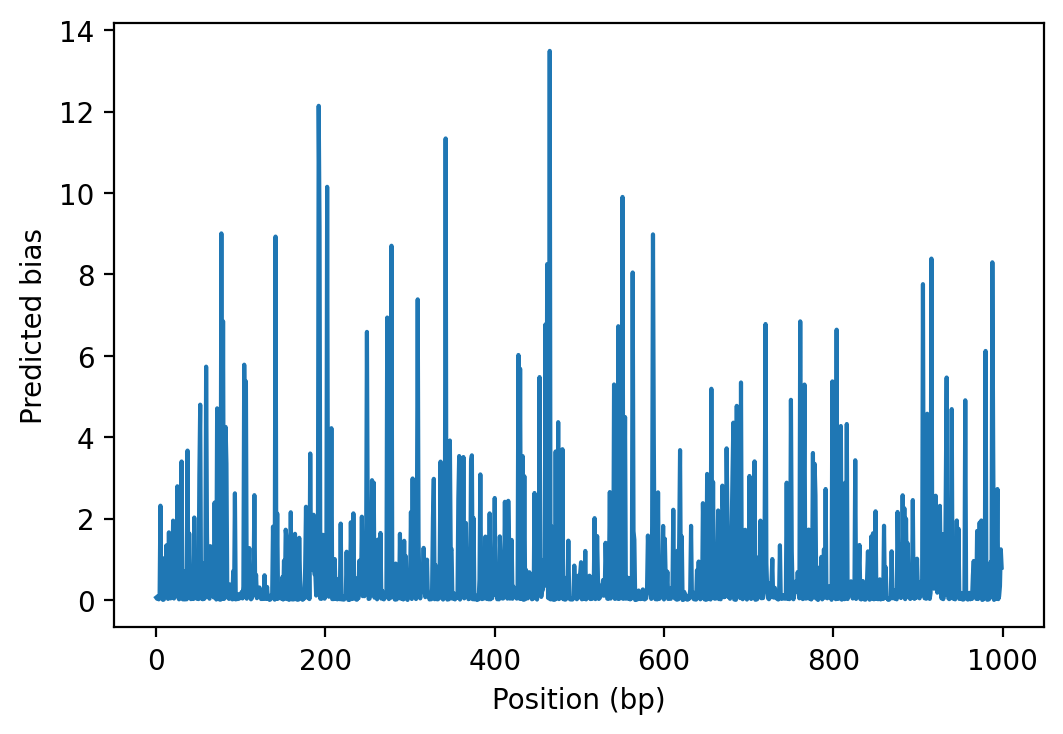

In [21]:
plt.figure(dpi = 200)
plt.plot(np.arange(len(pred_bias)), pred_bias)
plt.xlabel("Position (bp)")
plt.ylabel("Predicted bias")